In [53]:
import pandas as pd
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Adjust the width to display everything
pd.set_option('display.max_colwidth', None)  # Show full column content

import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob

from wordcloud import WordCloud , STOPWORDS

import emoji
import re

from collections import Counter

import plotly.graph_objs as go
from plotly.offline import iplot

import plotly.express as px

In [62]:
twitter_df = pd.read_csv(r"C:\Users\User\iCloudDrive\Cursos\Data Circle\DataCircle_Twitter_Project\twitter_cleaned_data.csv")

In [63]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014005 entries, 0 to 1014004
Data columns (total 15 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   created_at            1014005 non-null  object
 1   tweet_id              1014005 non-null  int64 
 2   tweet                 1014005 non-null  object
 3   likes                 1014005 non-null  int64 
 4   retweet_count         1014005 non-null  int64 
 5   source                1014002 non-null  object
 6   user_id               1014005 non-null  int64 
 7   user_join_date        1014005 non-null  object
 8   user_followers_count  1014005 non-null  int64 
 9   user_location         1009904 non-null  object
 10  city                  1014005 non-null  object
 11  state                 1014005 non-null  object
 12  candidate             1014005 non-null  object
 13  tweet_cleaned         1014005 non-null  object
 14  country               1014005 non-null  object
dty

In [64]:
twitter_df["created_at"] = pd.to_datetime(twitter_df["created_at"])
twitter_df["user_join_date"] = pd.to_datetime(twitter_df["user_join_date"])

In [65]:
# Fill null location columns with "unknown"
twitter_df["user_location"] = twitter_df["user_location"].fillna("unknown")

In [66]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014005 entries, 0 to 1014004
Data columns (total 15 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   created_at            1014005 non-null  datetime64[ns]
 1   tweet_id              1014005 non-null  int64         
 2   tweet                 1014005 non-null  object        
 3   likes                 1014005 non-null  int64         
 4   retweet_count         1014005 non-null  int64         
 5   source                1014002 non-null  object        
 6   user_id               1014005 non-null  int64         
 7   user_join_date        1014005 non-null  datetime64[ns]
 8   user_followers_count  1014005 non-null  int64         
 9   user_location         1014005 non-null  object        
 10  city                  1014005 non-null  object        
 11  state                 1014005 non-null  object        
 12  candidate             1014005 non-null  ob

In [82]:
# Visualization 2: Tweet Engagement (Likes and Retweets)

engagement_data = twitter_df.groupby('candidate').agg({'likes': 'sum', 'retweet_count': 'sum'}).reset_index()
fig = px.bar(engagement_data, x='candidate', y=['likes', 'retweet_count'], barmode='group', 
             title="Total Likes and Retweets by Candidate")
fig.show()

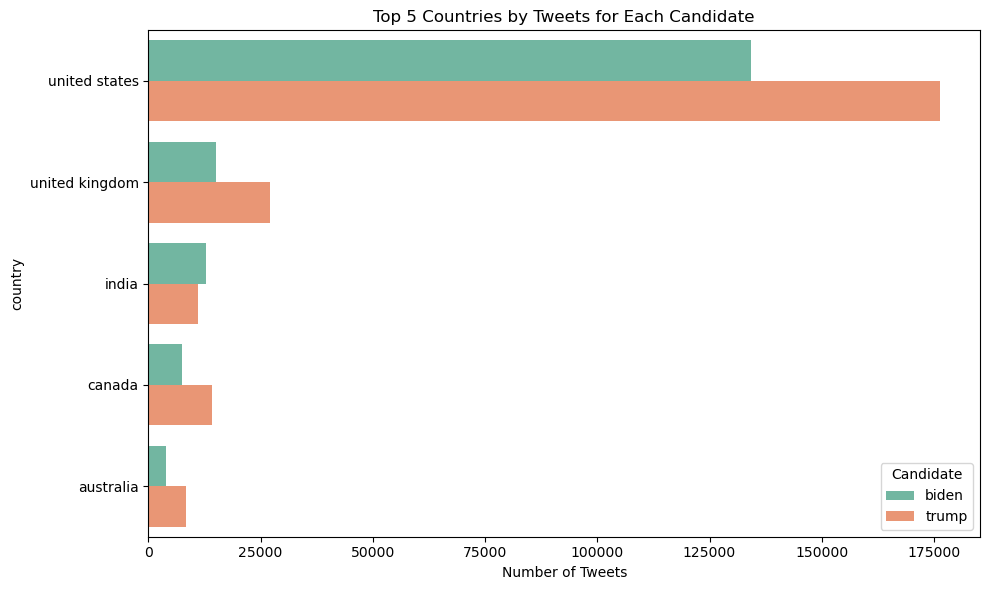

In [203]:
# Visualization 4: Top 5 Countries by Tweets
# Remove 'unknown' countries, stripping whitespace and making the comparison case-insensitive
filtered_df = twitter_df[twitter_df['country'].str.strip().str.lower() != 'unknown']

# Get the top 5 countries by tweet count for each candidate
top_countries_by_candidate = (
    filtered_df.groupby(['candidate', 'country'])
    .size()
    .reset_index(name='tweet_count')
)

# Get the top 5 countries for each candidate
top_countries = top_countries_by_candidate.sort_values(['candidate', 'tweet_count'], ascending=[True, False])
top_5_countries_per_candidate = top_countries.groupby('candidate').head(5)

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(data=top_5_countries_per_candidate, x='tweet_count', y='country', hue='candidate', palette='Set2')
plt.xlabel("Number of Tweets")
plt.title("Top 5 Countries by Tweets for Each Candidate")
plt.legend(title='Candidate')
plt.tight_layout()
plt.show()

In [83]:
engagement_data

,candidate,likes,retweet_count
0,biden,4217380,922091
1,trump,3349488,804469


In [95]:
engagement_data = twitter_df.groupby('candidate').agg({
    'likes': 'sum',          # Sum of likes for each candidate
    'retweet_count': 'sum',  # Sum of retweets for each candidate
    'tweet_id': 'count'      # Number of tweets (rows) for each candidate
}).reset_index()

engagement_data

,candidate,likes,retweet_count,tweet_id
0,biden,4217380,922091,417863
1,trump,3349488,804469,596142


In [92]:
twitter_df.groupby("candidate")["tweet"].count()

candidate
biden    417863
trump    596142
Name: tweet, dtype: int64

In [90]:
twitter_df.groupby("candidate")["retweet_count"].sum()

candidate
biden    922091
trump    804469
Name: retweet_count, dtype: int64

In [84]:
twitter_df.groupby("candidate")["likes"].sum()

candidate
biden    4217380
trump    3349488
Name: likes, dtype: int64

In [101]:
twitter_df.groupby("candidate")["likes"].sum() / twitter_df.groupby("candidate")["tweet"].count() * 100

candidate
biden    1009.273374
trump     561.860765
dtype: float64

In [97]:
twitter_df["likes"].describe()

count    1.014005e+06
mean     7.462358e+00
std      3.389073e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      1.657020e+05
Name: likes, dtype: float64

In [151]:
twitter_df.loc[twitter_df['likes'].idxmax()]

created_at                                                                                                                                                                                                                                                               2020-10-16 03:17:29
tweet_id                                                                                                                                                                                                                                                                 1316941303603728384
tweet                   Tonight a woman in the audience of Trump's town hall began her question by telling him he has a great smile &amp; he's so handsome when he smiles. And when #JoeBiden is President, hopefully that woman will be able to access better vision care, bless her heart.
likes                                                                                                                                            

In [179]:
highest_likes_row = twitter_df.loc[twitter_df["likes"].idxmax()]

# Extracting the user_id
user_id_with_highest_likes = highest_likes_row['user_id']

# Extracting the highest likes in a single tweet
highest_likes = highest_likes_row["likes"]

print("User ID with the highest likes:", user_id_with_highest_likes)
print("highest likes in a single tweet:", highest_likes)

User ID with the highest likes: 139823781
highest likes in a single tweet: 165702


In [180]:
# Group by user_id and sum the likes
likes_by_user = twitter_df.groupby('user_id')['likes'].sum().reset_index()

# Get the user_id with the highest sum of likes
highest_total_likes_user = likes_by_user.loc[likes_by_user['likes'].idxmax()]

# Extracting the user_id and the total likes
user_id_with_highest_total_likes = highest_total_likes_user['user_id']
total_likes = highest_total_likes_user['likes']

print("User ID with the highest sum of likes:", user_id_with_highest_total_likes)
print("Total likes:", total_likes)


User ID with the highest sum of likes: 139823781
Total likes: 577324


In [186]:
most_engaged_user_df = twitter_df.loc[twitter_df["user_id"]==user_id_with_highest_total_likes]

In [200]:
most_engaged_user_df["user_followers_count"].max()

2043747

# Sentiment and WordCloud Analysis

In [67]:
def get_sentiment(text):
    analysis = TextBlob(text)
    # Classify sentiment as positive, negative, or neutral
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

In [68]:
# Apply sentiment analysis to the 'tweet_cleaned' column
twitter_df['sentiment'] = twitter_df['tweet_cleaned'].apply(get_sentiment)

In [69]:
# Group by candidate and sentiment to get the counts
twitter_df.groupby(['candidate', 'sentiment']).size().unstack()

sentiment,negative,neutral,positive
candidate,,,
biden,68297,189805,159761
trump,131838,273214,191090


In [70]:
# Group by candidate and sentiment to get the counts
sentiment_by_candidate = twitter_df.groupby(['candidate', 'sentiment']).size().reset_index(name='count')

# Create the interactive bar chart with specified colors for each sentiment
fig = px.bar(
    sentiment_by_candidate,
    x='candidate',
    y='count',
    color='sentiment',
    title='Sentiment Analysis of Tweets for Biden and Trump',
    color_discrete_map={'positive': '#4caf50', 'neutral': '#ffeb3b', 'negative': '#f44336'},
    barmode='group',
    labels={'count': 'Number of Tweets', 'candidate': 'Candidate', 'sentiment': 'Sentiment'}
)

# Show the interactive plot
fig.show()

In [77]:
twitter_df.groupby('candidate')["sentiment"].value_counts(normalize=True).unstack().round(2)

sentiment,negative,neutral,positive
candidate,,,
biden,0.16,0.45,0.38
trump,0.22,0.46,0.32


In [76]:
# Group by candidate and sentiment to get the proportional counts
proportion_sentiment_by_candidate = (
    twitter_df.groupby(['candidate', 'sentiment']).size() / twitter_df.groupby('candidate').size()
).reset_index(name='proportion').round(2)

# Create the unstacked bar chart with proportions and specified colors for each sentiment
fig = px.bar(
    proportion_sentiment_by_candidate,
    x='candidate',
    y='proportion',
    color='sentiment',
    title='Proportional Sentiment Analysis of Tweets for Biden and Trump',
    color_discrete_map={'positive': 'green', 'neutral': 'yellow', 'negative': 'red'},
    barmode='group'
)
fig.show()

In [78]:
# Create a column with date only (without time)
twitter_df["created_at_date"] = twitter_df["created_at"].dt.date

biden_df = twitter_df[twitter_df['candidate']=='biden']
trump_df = twitter_df[twitter_df['candidate']=='trump']

# Group by date and sentiment for both datasets
biden_sentiment_over_time = biden_df.groupby(['created_at_date', 'sentiment']).size().unstack(fill_value=0)
# Group by date and sentiment for both datasets
trump_sentiment_over_time = trump_df.groupby(['created_at_date', 'sentiment']).size().unstack(fill_value=0)

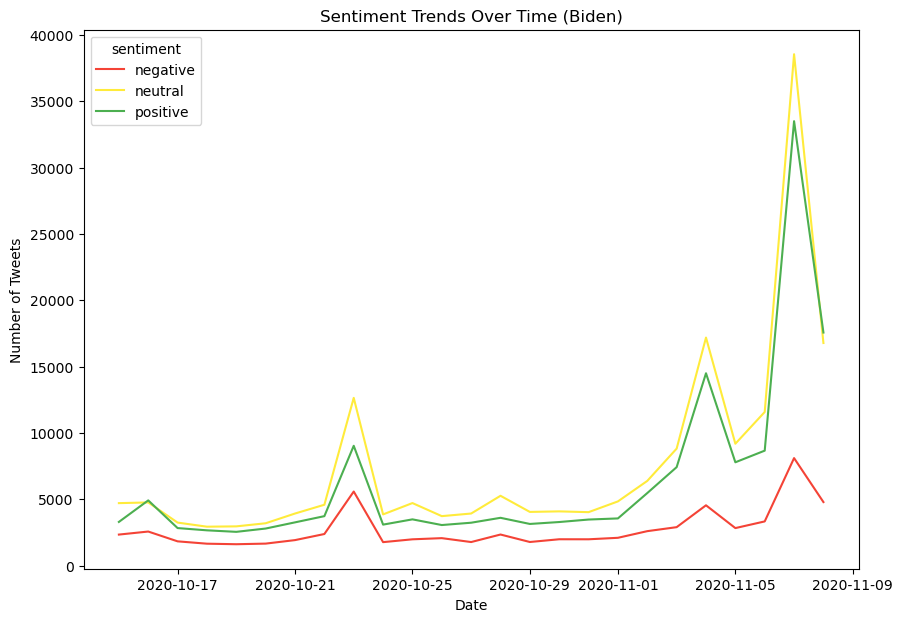

In [79]:
# Plot sentiment trends for Biden
biden_sentiment_over_time.plot(kind='line', figsize=(10, 7), color=['#f44336', '#ffeb3b', '#4caf50'])
plt.title('Sentiment Trends Over Time (Biden)')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.show()

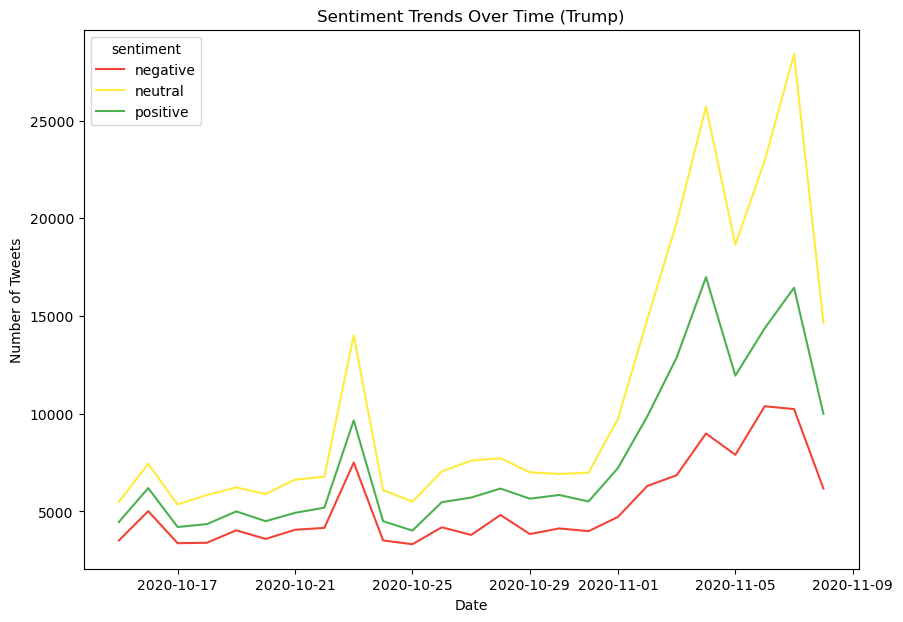

In [80]:
# Plot sentiment trends for Trump
trump_sentiment_over_time.plot(kind='line', figsize=(10, 7), color=['#f44336', '#ffeb3b', '#4caf50'])
plt.title('Sentiment Trends Over Time (Trump)')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.show()

In [ ]:
# Function to generate word cloud for a particular sentiment
def generate_wordcloud(df, sentiment):
    text = ' '.join(df[df['sentiment'] == sentiment]['tweet_cleaned'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f' {df['candidate'].unique()} {sentiment.capitalize()} Word Cloud', fontsize=20)
    plt.show()

# Generate word clouds for positive and negative tweets for Biden
generate_wordcloud(biden_df, 'positive')
generate_wordcloud(biden_df, 'negative')

# Generate word clouds for positive and negative tweets for Trump
generate_wordcloud(trump_df, 'positive')
generate_wordcloud(trump_df, 'negative')

In [76]:
# Group by state and sentiment to get counts
biden_sentiment_by_state = biden_df[(biden_df['country']=='united states')&(biden_df['state']!='unknown')].groupby(['state', 'sentiment']).size().unstack(fill_value=0)
trump_sentiment_by_state = trump_df[(trump_df['country']=='united states')&((trump_df['state']!='unknown'))].groupby(['state', 'sentiment']).size().unstack(fill_value=0)

In [ ]:
trump_sentiment_by_state

# Emoji Analysis

In [125]:
# Extract all emojis from tweet column and append to a list
all_emojis_list = []

recognized_emojis = set(emoji.EMOJI_DATA.keys())

for tweet in twitter_df['tweet']:
    for char in tweet:
        if char in recognized_emojis:
            all_emojis_list.append(char)

In [109]:
# Extract all emojis from tweet column and append to a list
all_emojis_list = []

for tweet in twitter_df['tweet']:
    for char in tweet:
        if char in emoji.EMOJI_DATA:
            all_emojis_list.append(char)

In [ ]:
all_emojis_list

In [ ]:
# Count top 10 emoji frequency
Counter(all_emojis_list).most_common(10)

In [136]:
# Extract only the emojis from the top 10 list
emojis = [Counter(all_emojis_list).most_common(10)[i][0] for i in range(10)]

In [137]:
# Extract only the frequency from the top 10 list
freqs = [Counter(all_emojis_list).most_common(10)[i][1] for i in range(10)]

In [ ]:
iplot([go.Bar(x=emojis , y=freqs)])

# Feature Engineering

In [150]:
# Create a new column for the number of days between 'created_at' and 'user_join_date'
twitter_df['days_between'] = (twitter_df['created_at'] - twitter_df['user_join_date']).dt.days

In [ ]:
# Calculate the correlation matrix
correlation_matrix = twitter_df[['likes', 'retweet_count', 'user_followers_count', 'days_between']].corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Set the title
plt.title('Correlation Heatmap')

# Show the plot
plt.show()